Import of packages

In [365]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns

from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, BatchNormalization, AveragePooling2D
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout

Function for loading the labeled dataset in correct order

In [366]:
def load_data(dataset_dir, labes_dir):
    # Load the labels
    labels_df = pd.read_csv(labes_dir)

    # Sort labels by ID to ensure the order matches the .npy file order
    labels_df = labels_df.sort_values('ID').reset_index(drop=True)

    # Initialize lists to collect data and labels
    data_list = []
    labels_list = []

    # Loop over IDs in order
    for idx, row in labels_df.iterrows():
        file_path = os.path.join(dataset_dir, f"{row['ID']}.npy")
        data = np.load(file_path)
        data_list.append(data)
        labels_list.append(row['target'])

    # Convert to numpy arrays
    dataset = np.array(data_list)
    dataset_labels = np.array(labels_list)
    
    return dataset, dataset_labels

Loading the dataset

In [367]:
TRAIN_DIR = 'C:/Users/Martin/Documents/REPO/MPA-MLF/Project/MPA-MLF_DATA_NEW/Train/'
TEST_DIR = 'C:/Users/Martin/Documents/REPO/MPA-MLF/Project/MPA-MLF_DATA_NEW/Test/'
LABEL_PATH = 'C:/Users/Martin/Documents/REPO/MPA-MLF/Project/MPA-MLF_DATA_NEW/label_train.csv'
EMPTY_LABEL_PATH = 'C:/Users/Martin/Documents/REPO/MPA-MLF/Project/MPA-MLF_DATA_NEW/test_format.csv'

dataset, dataset_labels = load_data(TRAIN_DIR, LABEL_PATH)
submition_data, submition_data_labels = load_data(TEST_DIR, EMPTY_LABEL_PATH)

print(f"Data shape: {dataset.shape}")
print(f"Labels shape: {dataset_labels.shape}")
print(f"Kaggle data shape: {submition_data.shape}")
print(f"Kaggle labels shape: {submition_data_labels.shape}")

nodeB_0 = dataset[dataset_labels == 0]
nodeB_1 = dataset[dataset_labels == 1]
nodeB_2 = dataset[dataset_labels == 2]
print("Num of nodeB_0:", nodeB_0.shape[0], "\nNum of nodeB_1:", nodeB_1.shape[0], "\nNum of nodeB_2:", nodeB_2.shape[0], "\n")

Data shape: (1491, 72, 48)
Labels shape: (1491,)
Kaggle data shape: (120, 72, 48)
Kaggle labels shape: (120,)
Num of nodeB_0: 1209 
Num of nodeB_1: 141 
Num of nodeB_2: 141 



Visualise one train LTE frame sample

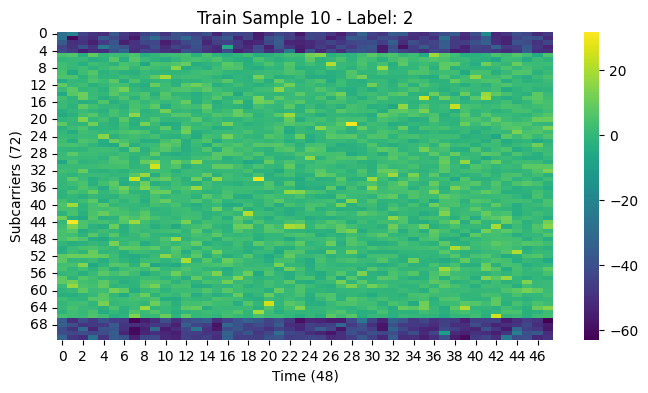

In [368]:
i = 10
plt.figure(figsize=(8, 4))
sns.heatmap(dataset[i], cmap='viridis')
plt.title(f"Train Sample {i} - Label: {int(dataset_labels[i])}")
plt.xlabel("Time (48)")
plt.ylabel("Subcarriers (72)")
plt.show()

In [369]:
x_train, x_test, y_train, y_test = train_test_split(dataset, dataset_labels, test_size=0.2, random_state=42)

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("Training")
print("Num of nodeB_0:", np.count_nonzero(y_train == 0), "\nNum of nodeB_1:", np.count_nonzero(y_train == 1), "\nNum of nodeB_2:", np.count_nonzero(y_train == 2), "\n")
print("Testing")
print("Num of nodeB_0:", np.count_nonzero(y_test == 0), "\nNum of nodeB_1:", np.count_nonzero(y_test == 1), "\nNum of nodeB_2:", np.count_nonzero(y_test == 2), "\n")


x_sub = submition_data

x_train_aug, x_val, y_train_aug, y_val = train_test_split(
    x_train, 
    y_train, 
    test_size=0.2, 
    stratify=y_train, 
    random_state=42
)

print("X_train before augmentation shape:", x_train_aug.shape)
print("x validation shape:", x_val.shape)



x_train shape: (1192, 72, 48)
x_test shape: (299, 72, 48)
Training
Num of nodeB_0: 975 
Num of nodeB_1: 103 
Num of nodeB_2: 114 

Testing
Num of nodeB_0: 234 
Num of nodeB_1: 38 
Num of nodeB_2: 27 

X_train before augmentation shape: (953, 72, 48)
x validation shape: (239, 72, 48)


In [370]:
nodeB_0 = x_train_aug[y_train_aug == 0]
nodeB_1 = x_train_aug[y_train_aug == 1]
nodeB_2 = x_train_aug[y_train_aug == 2]
print("Num of nodeB_0:", nodeB_0.shape[0], "\nNum of nodeB_1:", nodeB_1.shape[0], "\nNum of nodeB_2:", nodeB_2.shape[0], "\n")

for k in range(2):
    nodeB_0 = nodeB_0 + np.random.normal(0, 3, (nodeB_0.shape[0], nodeB_0.shape[1], nodeB_0.shape[2]))
    x_train_aug = np.append(x_train_aug, nodeB_0, 0)
    y_train_aug = np.append(y_train_aug, np.zeros(nodeB_0.shape[0]))
    
N_nodeB_0 = np.count_nonzero(dataset_labels == 0)

for k in range(N_nodeB_0//nodeB_1.shape[0]):
    nodeB_1 = nodeB_1 + np.random.normal(0, 1+k//3, (nodeB_1.shape[0], nodeB_1.shape[1], nodeB_1.shape[2]))
    x_train_aug = np.append(x_train_aug, nodeB_1, 0)
    y_train_aug = np.append(y_train_aug, np.ones(nodeB_1.shape[0]))

for k in range(N_nodeB_0//nodeB_2.shape[0]):
    nodeB_2 = nodeB_2 + np.random.normal(0, 1+k//3, (nodeB_2.shape[0], nodeB_2.shape[1], nodeB_2.shape[2]))
    x_train_aug = np.append(x_train_aug, nodeB_2, 0)
    y_train_aug = np.append(y_train_aug, 2 * np.ones(nodeB_2.shape[0]))
    
print("Enlarged dataset")
print("Num of nodeB_0:", np.count_nonzero(y_train_aug == 0), "\nNum of nodeB_1:", np.count_nonzero(y_train_aug == 1), "\nNum of nodeB_2:", np.count_nonzero(y_train_aug == 2), "\n")

print("Final size of dataset: ", x_train_aug.shape)

Num of nodeB_0: 780 
Num of nodeB_1: 82 
Num of nodeB_2: 91 

Enlarged dataset
Num of nodeB_0: 2340 
Num of nodeB_1: 1230 
Num of nodeB_2: 1274 

Final size of dataset:  (4844, 72, 48)


In [371]:
# normalization of training data
x_train_mean = np.mean(x_train)
x_train_deviation = np.std(x_train)
x_train_normalized = (x_train - x_train_mean) / x_train_deviation

# normalization of validation data
x_val_mean = np.mean(x_val)
x_val_deviation = np.std(x_val)
x_val_normalized = (x_val - x_val_mean) / x_val_deviation

# normalization of test data
x_test_mean = np.mean(x_test)
x_test_deviation = np.std(x_test)
x_test_normalized = (x_test - x_test_mean) / x_test_deviation

# normalization of submition data
x_sub_mean = np.mean(x_sub)
x_sub_deviation = np.std(x_sub)
x_sub_normalized = (x_sub - x_sub_mean) / x_sub_deviation

x_train_normalized = x_train_normalized.reshape(-1, 72, 48, 1)
x_val_normalized = x_val_normalized.reshape(-1, 72, 48, 1)
x_test_normalized = x_test_normalized.reshape(-1, 72, 48, 1)
x_sub_normalized = x_sub_normalized.reshape(-1, 72, 48, 1)

y_train_encoded = to_categorical(y_train, num_classes=3)
y_val_encoded = to_categorical(y_val, num_classes=3)
y_test_encoded = to_categorical(y_test, num_classes=3)

In [372]:
model = Sequential()

model.add(Input(shape=(72, 48, 1)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate = 0.001), metrics=['accuracy'])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_37 (Conv2D)              │ (None, 72, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 36, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 36, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 36, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 18, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 18, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_29 (Flatten)            │ (None, 27648)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 64)             │     1,769,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,846,211 (7.04 MB)

 Trainable params: 1,846,211 (7.04 MB)

 Non-trainable params: 0 (0.00 B)

In [373]:
history = model.fit(
    x_train_normalized, 
    y_train_encoded, 
    epochs=30, 
    batch_size=10, 
    validation_data=(x_val_normalized, y_val_encoded),
    callbacks=[early_stopping]
)

Epoch 1/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.7663 - loss: 0.7576 - val_accuracy: 0.9289 - val_loss: 0.3370
Epoch 2/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9071 - loss: 0.3177 - val_accuracy: 0.9874 - val_loss: 0.0806
Epoch 3/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9741 - loss: 0.0766 - val_accuracy: 0.9749 - val_loss: 0.0815
Epoch 4/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9866 - loss: 0.0573 - val_accuracy: 0.9916 - val_loss: 0.0309
Epoch 5/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9889 - loss: 0.0340 - val_accuracy: 0.9916 - val_loss: 0.0299
Epoch 6/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9828 - loss: 0.0395 - val_accuracy: 0.9916 - val_loss: 0.0226
Epoch 7/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9942 - loss: 0.0241 - val_accuracy: 0.9916 - val_loss: 0.0176
Epoch 8/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9967 - loss: 0.0183 - val_accu

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9973 - loss: 0.0218  
Test loss: 0.026564117521047592
Test accuracy: 99.6655523777008 %


' y_pred = model.predict(x_test_normalized)\n#print(y_pred)\ny_pred_classes = np.argmax(y_pred, axis=1)\ny_true_classes = np.argmax(y_test_encoded, axis=1)\n#print(y_pred_classes)\n#print(y_true_classes)\ncm = confusion_matrix(y_true_classes, y_pred_classes)\nprint(cm)\nConfusionMatrixDisplay.from_predictions(y_true_classes,y_pred_classes)\nplt.show() '

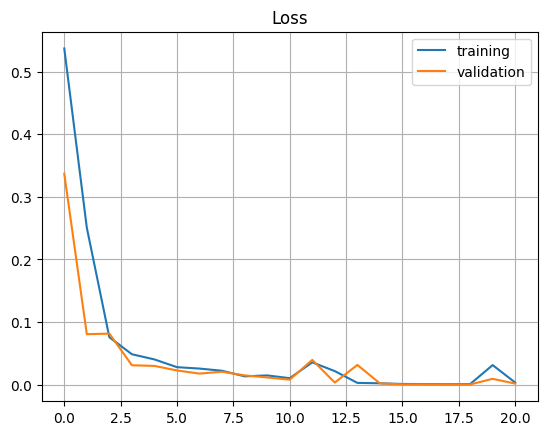

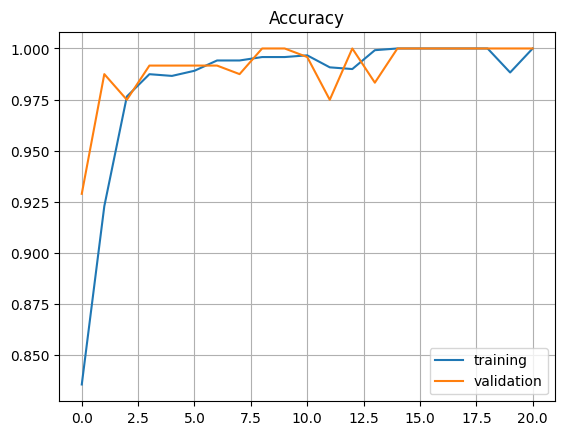

In [374]:
score = model.evaluate(x_test_normalized, y_test_encoded, verbose=1)
print('Test loss:', score[0])
print(f'Test accuracy: {score[1]*100} %')


#extract_data.load_data("MPA-MLF_data\Test", (72, 48))

plt.figure()
plt.title('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.grid('both')
plt.figure()
plt.title('Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.grid('both')

""" y_pred = model.predict(x_test_normalized)
#print(y_pred)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)
#print(y_pred_classes)
#print(y_true_classes)
cm = confusion_matrix(y_true_classes, y_pred_classes)
print(cm)
ConfusionMatrixDisplay.from_predictions(y_true_classes,y_pred_classes)
plt.show() """

In [375]:
y_pred = model.predict(x_sub_normalized)
#print(y_pred)
y_pred_classes = np.argmax(y_pred, axis=1)
print(y_pred_classes)

import csv
with open('label_test_MT_v0.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['ID', 'target'])  # Write header
    for i, value in enumerate(y_pred_classes):
        writer.writerow([i, value])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[1 0 1 1 0 0 2 0 2 0 1 1 1 0 1 2 0 2 2 2 0 0 2 1 0 0 2 1 1 1 2 0 2 2 2 0 2
 0 0 0 1 2 1 0 1 2 1 0 2 1 1 0 2 0 0 1 0 1 2 0 2 1 1 2 1 1 2 1 0 2 1 1 2 2
 2 1 1 2 2 2 0 1 2 2 0 2 0 1 0 2 2 1 2 0 2 0 0 2 0 0 0 0 2 1 2 2 1 0 1 2 2
 0 1 1 0 1 2 0 0 1]
